In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
# 数据归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  car  bird   dog   car
torch.Size([4, 3, 32, 32])


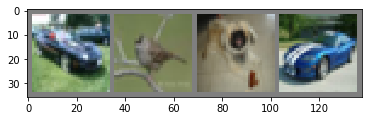

In [15]:
import matplotlib.pylab as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print(images.size())

In [20]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.pool(F.relu(self.conv1(x)))
        # If the size is a square you can only specify a single number
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print("[{0}, {1}] loss: {2}".format(epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1, 2000] loss: 1.975081443488598
[1, 4000] loss: 1.717072043567896
[1, 6000] loss: 1.5995608870089053
[1, 8000] loss: 1.5229524226784705
[1, 10000] loss: 1.4927166827470064
[1, 12000] loss: 1.4516923731267453
[2, 2000] loss: 1.3846806463897228
[2, 4000] loss: 1.362033695653081
[2, 6000] loss: 1.3454455039352178
[2, 8000] loss: 1.3301519719660282
[2, 10000] loss: 1.284998901799321
[2, 12000] loss: 1.266552554383874
Finished Training


  cat  ship  ship plane
torch.Size([4, 3, 32, 32])


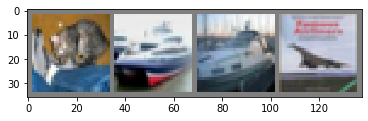

In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print(images.size())

In [25]:
outputs = net(images)

In [26]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('{}'.format(classes[predicted[j]]) for j in range(4)))

Predicted:  cat ship car plane


In [30]:
correct, total = 0, 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: {}'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 53.21


In [32]:
class_correct, class_total = list(0. for i in range(10)), list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of {0}: {1}'.format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 72.9
Accuracy of car: 73.2
Accuracy of bird: 39.8
Accuracy of cat: 44.7
Accuracy of deer: 42.9
Accuracy of dog: 29.4
Accuracy of frog: 74.1
Accuracy of horse: 51.2
Accuracy of ship: 69.2
Accuracy of truck: 34.7


In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [34]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [38]:
inputs, labels = inputs.to(device), labels.to(device)